In [123]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import tensorflow as tf
import tensorflow_datasets as tfds
import os

In [124]:
width=75
height=75
normalized_coordinates=True

 ### Draws a bounding box on an image (optionally with labels) using given coordinates.

In [125]:
def draw_bb_on_img(rgb_img, xmin, ymin, xmax, ymax, colour="red", thickness=1,
               display_str_list=(), normalized_coordinates=True):
  draw=PIL.ImageDraw.Draw(rgb_img)
  width, height=rgb_img.size
  if normalized_coordinates:
    (left, right, top, bottom)=(xmin*width, xmax*width, ymin*height, ymax*height)
  else:
    (left, right, top, bottom)=(xmin, xmax, ymin, ymax)
  draw.line([(top, left), (bottom, left), (bottom, right), (top, right), (top, left)],
            width=thickness,
            fill=colour)

### Draws multiple bounding boxes on an image.

In [126]:
def draw_bbs_on_img(rgb_img, b, colour=[], thickness=1, display_str_list=()):
  boxes_shape=b.shape
  if not boxes_shape:
    return
  if len(boxes_shape)!=2 or boxes_shape[1]!=4:
    raise ValueError("Input must be of size [N, 4]")
  for i in range(boxes_shape[0]):
    draw_bb_on_img(rgb_img, b[i, 1], b[i, 0], b[i, 3], b[i, 2],
                   colour[i], thickness, display_str_list[i])

### Draw multiple bounding boxes on a NumPy image array and return the modified image as a NumPy array.

In [127]:
def draw_bbs_on_img_array(img, b, colour=[], thickness=1, display_str_list=()):
  img_PIL=PIL.Image.fromarray(img)
  rgb_img=PIL.Image.new("RGBA", img_PIL.size)
  rgb_img.paste(img_PIL)
  draw_bbs_on_img(rgb_img, b, colour, thickness, display_str_list)
  return np.array(rgb_img)

### Converts a TensorFlow dataset (`train_ds`, `val_ds`, `test_ds`) into NumPy arrays — extracting one batch from each split.

In [128]:
def dataset_to_numpy(train_ds, val_ds, test_ds, N):

  batch_train_ds=train_ds.unbatch().batch(N)

  if tf.executing_eagerly():
    for val_digits, (val_labels, val_boxes) in val_ds:
      val_digits=val_digits.numpy()
      val_labels=val_labels.numpy()
      val_boxes=val_boxes.numpy()
      break
    for train_digits, (train_labels, train_boxes) in batch_train_ds:
      train_digits=train_digits.numpy()
      train_labels=train_labels.numpy()
      train_boxes=train_boxes.numpy()
      break
    for test_digits, (test_labels, test_boxes) in test_ds:
      test_digits=test_digits.numpy()
      test_labels=test_labels.numpy()
      test_boxes=test_boxes.numpy()
      break

  if len(val_labels.shape)>1:
    val_labels=np.argmax(val_labels, axis=1)
  if len(train_labels.shape)>1:
    train_labels=np.argmax(train_labels, axis=1)
  if len(test_labels.shape)>1:
    test_labels=np.argmax(test_labels, axis=1)

  return (val_digits, val_labels, val_boxes,
          train_digits, train_labels, train_boxes,
          test_digits, test_labels, test_boxes)

### Draw multiple bounding boxes (and optionally labels) on a NumPy image array and return the modified image as a NumPy array.

In [129]:
plt_font_dir=os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def create_digit_from_local_fonts(n):

  font_labels=[]
  img=PIL.Image.new("LA", (75*n, 75), color=(0, 255))
  font1=PIL.ImageFont.truetype(os.path.join(plt_font_dir, "DejaVuSansMono-Oblique.ttf"), 25)
  font2=PIL.ImageFont.truetype(os.path.join(plt_font_dir, "STIXGeneral.ttf"), 25)
  d=PIL.ImageDraw.Draw(img)

  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*75, 0 if i<10 else -4), str(i%10), fill=(255, 255), font=font1 if i<10 else font2)

  font_digits=np.array(img, np.float32)[:, 0]/255
  font_digits=np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0))
  return font_digits, font_labels

### Generates synthetic digit images using local system fonts (from matplotlib) and returns them as a NumPy array along with corresponding digit labels.

In [130]:
def display_digits_with_boxes(digits, preds, labels, pred_boxes, boxes, iou, title, seed=16, iou_threshold=0.5):

  n=10
  row=1
  column=10
  np.random.seed(seed)
  indexes=np.random.choice(len(digits), size=n, replace=False)
  n_digits=digits[indexes]
  n_preds=preds[indexes]
  n_labels=labels[indexes]
  n_iou=[]

  if len(iou)>0:
    n_iou=iou[indexes]
  if len(pred_boxes)>0:
    n_pred_boxes=pred_boxes[indexes]
  if len(boxes)>0:
    n_boxes=boxes[indexes]

  n_digits=n_digits*255.0
  n_digits=n_digits.reshape(n, 75, 75)
  fig=plt.figure(figsize=(20, 5))
  plt.title(title)
  plt.xticks([])
  plt.yticks([])

  for i in range(n):
    ax=fig.add_subplot(row, column, i+1)
    boxes_to_plot=[]
    c=[]
    dsl=[]
    if len(boxes)>i:
      boxes_to_plot.append(n_boxes[i])
      c.append("red")
      dsl.append("True")
    if len(pred_boxes)>i:
      boxes_to_plot.append(n_pred_boxes[i])
      c.append("blue")
      dsl.append("Prediction")

    img_to_draw=draw_bbs_on_img_array(img=n_digits[i],
                                      b=np.asarray(boxes_to_plot),
                                      colour=c,
                                      display_str_list=dsl)
    ax.set_xlabel(f"True : {n_labels[i]}\nPredicted : {n_preds[i]}")
    plt.xticks([])
    plt.yticks([])

    if n_preds[i]!=n_labels[i]:
      ax.xaxis.label.set_color('red')

    plt.imshow(img_to_draw)

    if len(iou)>i:
      colour="black"
      if n_iou[i][0]<iou_threshold:
        colour="orange"
      ax.text(0.2, -0.5, "iou : %s"%(n_iou[i][0]), color=colour, transform=ax.transAxes)

### To plot training and validation metrics from a Keras `history` object.

In [131]:
def plot_metrics(history, metric_name, title):
  plt.title(title)
  plt.plot(history.history[metric_name], "b.-", label=metric_name)
  plt.plot(history.history["val_"+metric_name], "r.-", label="val_"+metric_name)

### Preprocesses an image-label pair from a TensorFlow Datasets (TFDS) digit dataset (like MNIST) by:

- Placing the `28x28` digit randomly inside a `75x75` canvas.

- Normalizing pixel values and computing a bounding box.

- Returning the padded image, one-hot label, and bounding box.

In [132]:
def read_image_tfds(img, label):

  xmin=tf.random.uniform((), 0, 48, dtype=tf.int32)
  ymin=tf.random.uniform((), 0, 48, dtype=tf.int32)

  img=tf.reshape(img, (28, 28, 1))
  img=tf.image.pad_to_bounding_box(img, ymin, xmin, 75, 75)
  img=tf.cast(img, tf.float32)/255.0

  xmin=tf.cast(xmin, tf.float32)
  ymin=tf.cast(ymin, tf.float32)

  xmax=(xmin+28)/75
  ymax=(ymin+28)/75
  xmin=xmin/75
  ymin=ymin/75

  box=tf.stack([xmin, ymin, xmax, ymax])
  return img, (tf.one_hot(label, 10), box)

- `tf.distribute.get_strategy()` retrieves the default distribution strategy.
- `strategy.num_replicas_in_sync` tells you how many devices (replicas) are working in parallel under that strategy.

In [133]:
strategy=tf.distribute.get_strategy()
strategy.num_replicas_in_sync

1

In [134]:
BATCH_SIZE=64*strategy.num_replicas_in_sync
BATCH_SIZE

64

In [135]:
# base_ds="mnist"
# base_ds="fashion_mnist"
base_ds="kmnist"

### These functions create TensorFlow input pipelines for training, validation, and testing datasets using `tf.data` and `tf.distribute.Strategy` for distributed training.

In [136]:
def get_train_ds():

  with strategy.scope():
    ds=tfds.load(base_ds, split="train[:80%]", as_supervised=True, try_gcs=True)
    ds=ds.map(read_image_tfds, num_parallel_calls=16)
    ds.shuffle(5000, reshuffle_each_iteration=True)
    ds=ds.repeat()
    ds=ds.batch(BATCH_SIZE, drop_remainder=True)
    ds=ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [137]:
def get_val_ds():

  with strategy.scope():
    ds=tfds.load(base_ds, split="train[80%:]", as_supervised=True, try_gcs=True)
    ds=ds.map(read_image_tfds, num_parallel_calls=16)
    ds=ds.batch(10000, drop_remainder=True)
  return ds

In [138]:
def get_test_ds():

  with strategy.scope():
    ds=tfds.load(base_ds, split="test", as_supervised=True, try_gcs=True)
    ds=ds.map(read_image_tfds, num_parallel_calls=16)
    ds=ds.batch(10000, drop_remainder=True)
  return ds

### This ensures that all variables and datasets created within the block are compatible with distributed training.

In [139]:
with strategy.scope():
  train_ds=get_train_ds()
  val_ds=get_val_ds()
  test_ds=get_test_ds()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.YR7OVD_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.YR7OVD_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.


### Breaking the data

In [140]:
(val_digits, val_labels, val_boxes,
 train_digits, train_labels, train_boxes,
 test_digits, test_labels, test_boxes)=dataset_to_numpy(train_ds, val_ds, test_ds, 10)

### Let us visualize a batch of the training data

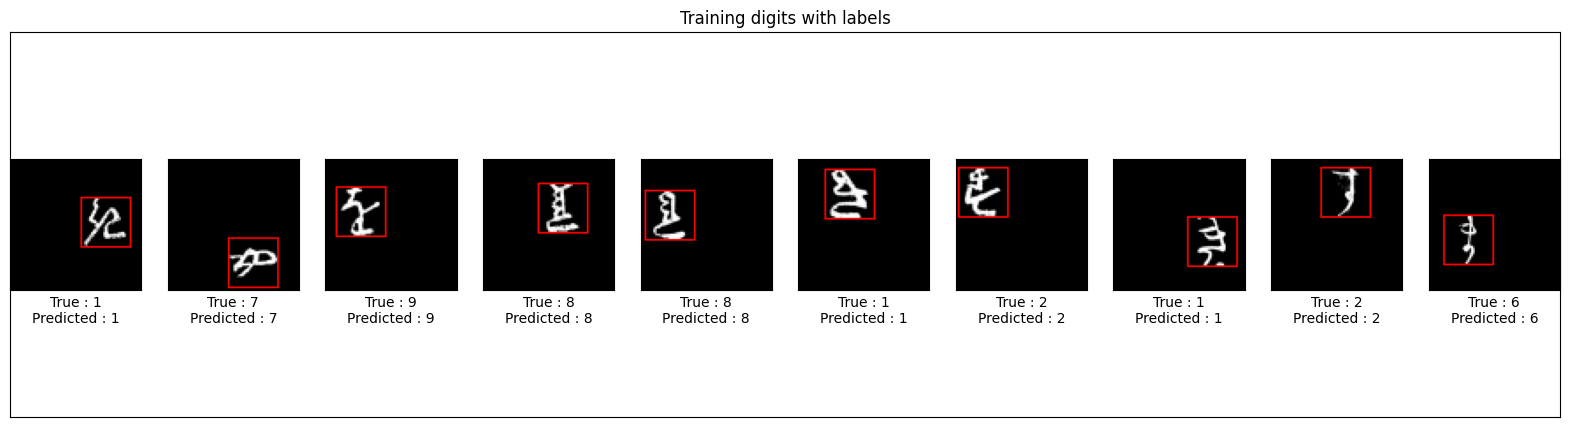

In [141]:
display_digits_with_boxes(train_digits,
                          train_labels,
                          train_labels,  # predicted labels (same here)
                          np.array([]),
                          train_boxes,
                          np.array([]),
                          "Training digits with labels")

### This function defines a simple CNN-based feature extractor using TensorFlow Keras layers.

In [142]:
def feature_extraction(inputs):

  x=tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75, 75, 1))(inputs)
  x=tf.keras.layers.AveragePooling2D((2, 2))(x)

  x=tf.keras.layers.Conv2D(32, activation='relu', kernel_size=3)(x)
  x=tf.keras.layers.AveragePooling2D((2, 2))(x)

  x=tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3)(x)
  x=tf.keras.layers.AveragePooling2D((2, 2))(x)

  return x

### This function defines a simple dense block (fully connected) for a neural network

In [143]:
def dense_layers(inputs):

  x=tf.keras.layers.Flatten()(inputs)
  x=tf.keras.layers.Dense(128, activation='relu')(x)

  return x

### This function defines the classification head of the model.

In [144]:
def classifier(inputs):

  o_p=tf.keras.layers.Dense(10, activation='softmax', name='classification')(inputs)

  return o_p

### This defines the bounding box regression head of the model.

In [145]:
def bounding_box_regression(inputs):

  o_p=tf.keras.layers.Dense(4, name='bounding_box')(inputs)

  return o_p

### Sequential image augmentation pipeline using Keras preprocessing layers.

In [146]:
img_aug=tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

### Now let us build a multi-output neural network model.

In [147]:
def model(inputs):

  inputs=img_aug(inputs)
  feature_cnn=feature_extraction(inputs)
  dense_o_p=dense_layers(feature_cnn)
  classification_o_p=classifier(dense_o_p)
  bounding_box_o_p=bounding_box_regression(dense_o_p)

  Model=tf.keras.Model(inputs=inputs, outputs=[classification_o_p, bounding_box_o_p])

  return Model

In [148]:
def define_and_compile_model(inputs):

  Model=model(inputs)
  Model.compile(optimizer="adam",
                loss={
                    "classification":"categorical_crossentropy",
                    "bounding_box":"mse"
                },
                metrics={
                    "classification":"accuracy",
                    "bounding_box":"mse"
                })

  return Model

In [149]:
lr_sched=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    factor=0.5,
    min_lr=1e-6,
    verbose=1
)

In [150]:
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [151]:
with strategy.scope():
  input=tf.keras.layers.Input(shape=(75, 75, 1))
  Model=define_and_compile_model(input)

Model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_61CLO… │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 73, 73,    │        160 │ keras_tensor_61C… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_9 │ (None, 36, 36,    │          0 │ conv2d_9[1][0]    │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 34, 34,    │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 17, 17,    │          0 │ conv2d_10[1][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 15, 15,    │     18,496 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 7, 7, 64)  │          0 │ conv2d_11[1][0]   │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 3136)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │    401,536 │ flatten_3[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 10)        │      1,290 │ dense_3[1][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bounding_box        │ (None, 4)         │        516 │ dense_3[1][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 426,638 (1.63 MB)

 Trainable params: 426,638 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

### Training phase

In [152]:
EPOCHS=20
steps_per_epoch=60000//BATCH_SIZE

history=Model.fit(train_ds,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_ds,
                  validation_steps=1,
                  epochs=EPOCHS,
                  callbacks=[lr_sched, early_stop])

loss, classification_loss, bounding_box_loss, classification_acc, bounding_box_mse=Model.evaluate(val_ds, steps=1)

Epoch 1/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - bounding_box_loss: 0.0218 - bounding_box_mse: 0.0218 - classification_accuracy: 0.3209 - classification_loss: 1.8456 - loss: 1.8673 - val_bounding_box_loss: 0.0143 - val_bounding_box_mse: 0.0143 - val_classification_accuracy: 0.7441 - val_classification_loss: 0.7899 - val_loss: 0.8042 - learning_rate: 0.0010
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - bounding_box_loss: 0.0124 - bounding_box_mse: 0.0124 - classification_accuracy: 0.7905 - classification_loss: 0.6527 - loss: 0.6651 - val_bounding_box_loss: 0.0071 - val_bounding_box_mse: 0.0071 - val_classification_accuracy: 0.8563 - val_classification_loss: 0.4503 - val_loss: 0.4574 - learning_rate: 0.0010
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - bounding_box_loss: 0.0058 - bounding_box_mse: 0.0058 - classification_accuracy: 0.8678 - classification_loss: 0.4208 - loss: 0.4265 - val_bounding_box_loss: 0.0037 - val_bounding_box_mse: 0.0037 - val_classificati

### Let us visualize the metrics

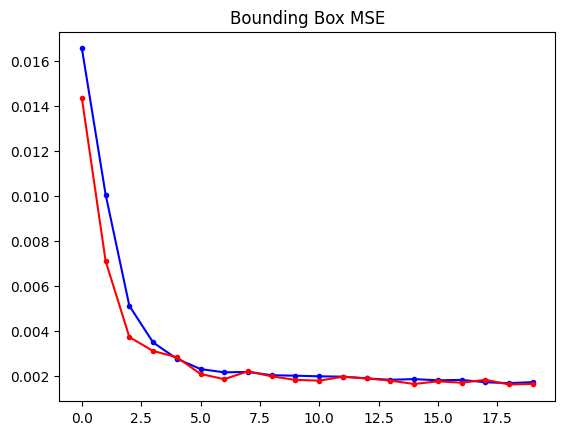

In [153]:
plot_metrics(history, "bounding_box_mse", "Bounding Box MSE")

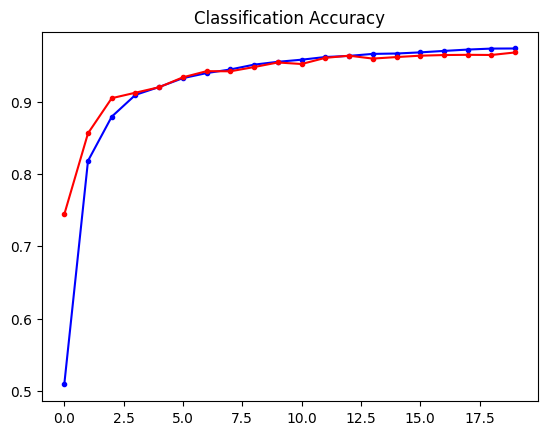

In [154]:
plot_metrics(history, "classification_accuracy", "Classification Accuracy")

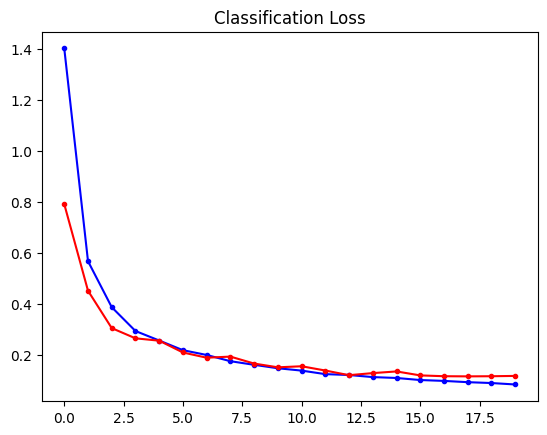

In [155]:
plot_metrics(history, "classification_loss", "Classification Loss")

### This function computes the Intersection over Union (IOU) between predicted and ground truth bounding boxes.

In [156]:
def intersection_over_union(pred_box, true_box):

  xmin_pred, ymin_pred, xmax_pred, ymax_pred=np.split(pred_box, 4, axis=1)
  xmin_true, ymin_true, xmax_true, ymax_true=np.split(true_box, 4, axis=1)

  smoothing_factor=1e-10

  xmin_overlap=np.maximum(xmin_pred, xmin_true)
  xmax_overlap=np.minimum(xmax_pred, xmax_true)
  ymin_overlap=np.maximum(ymin_pred, ymin_true)
  ymax_overlap=np.minimum(ymax_pred, ymax_true)

  pred_box_area=(xmax_pred-xmin_pred)*(ymax_pred-ymin_pred)
  true_box_area=(xmax_true-xmin_true)*(ymax_true-ymin_true)

  overlap_area=np.maximum((xmax_overlap-xmin_overlap), 0)*np.maximum((ymax_overlap-ymin_overlap), 0)
  union_area=pred_box_area+true_box_area-overlap_area

  iou=(overlap_area+smoothing_factor)/(union_area+smoothing_factor)
  iou=np.round(iou, 4)

  return iou

### Let us make the predictions

In [157]:
from sklearn.metrics import accuracy_score

In [158]:
prediction=Model.predict(val_digits, batch_size=BATCH_SIZE)
predicted_labels=np.argmax(prediction[0], axis=1)
predicted_boxes=prediction[1]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [159]:
acc_v=accuracy_score(val_labels, predicted_labels)
print(f"Accuracy : {acc_v*100}%")

Accuracy : 96.53%


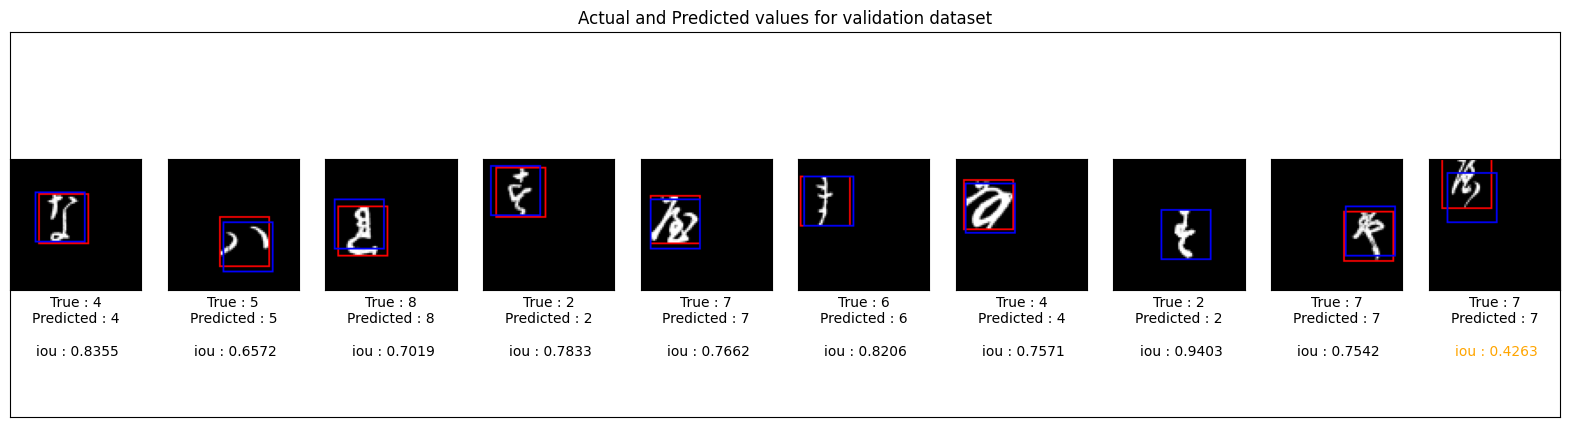

In [160]:
iou=intersection_over_union(predicted_boxes, val_boxes)
display_digits_with_boxes(val_digits,
                          predicted_labels,
                          val_labels,
                          predicted_boxes,
                          val_boxes,
                          iou,
                          "Actual and Predicted values for validation dataset")

In [161]:
prediction=Model.predict(test_digits, batch_size=BATCH_SIZE)
predicted_labels=np.argmax(prediction[0], axis=1)
predicted_boxes=prediction[1]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [162]:
acc_t=accuracy_score(test_labels, predicted_labels)
print(f"Accuracy : {acc_t*100}%")

Accuracy : 91.58%


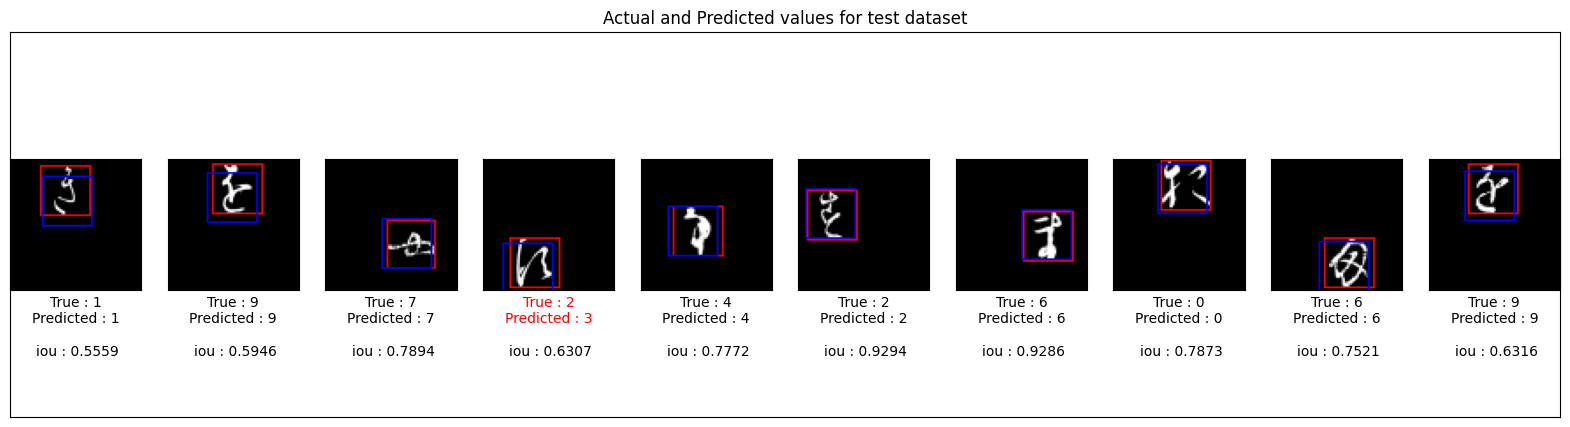

In [163]:
iou=intersection_over_union(predicted_boxes, test_boxes)
display_digits_with_boxes(test_digits,
                          predicted_labels,
                          test_labels,
                          predicted_boxes,
                          test_boxes,
                          iou,
                          "Actual and Predicted values for test dataset")